## 모델 구조 정의
- 사전학습된 파라미터를 사용하기위해 모델구조 정의

In [1]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import time
import cv2
import numpy as np
import datetime
import matplotlib.pyplot as plt
import imutils
from imutils.perspective import four_point_transform

In [2]:

# 다른 모듈에서 import * 할 때 가져올것들 정의
# __all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']


# 사용가능한 여러버전의 resnet 사전학습모델들. 버전마다 속도, 성능등 특징이다르다
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


# 3x3 컨볼루션 레이어정의 => 이렇게 사용하는것을 헬퍼 함수라한다
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

# ResNet 아키텍처에서 사용되는 기본 요소 클래스
class BasicBlock(nn.Module):
    #ResNet에서 사용되는 확장의 비율
    #출력 피쳐와 입력 피쳐가 같기때문에 1이다
    expansion = 1
    
    #레이어 정의
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        
    # 네트워크 연결 정의(순전파 함수)
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        # 선택적으로 다운샘플링도 한다
        # 입력과 출력의 차원을 맞추기위한 용도
        if self.downsample is not None:
            identity = self.downsample(x)
            
        # shortcut connection이라 한다
        # 입력에 출력을 더한다 =>잔차를 구하는 것이다
        # 네트워크가 학습하는것은 잔차이다 => 이런 모델학습을 residual learning 이라한다
        # 네트워크가 깊어질때 vanishing gradient 문제를 완화
        out += identity
        out = self.relu(out)

        return out


# ResNet에서 네트워크가 깊어져도 파라미터를 효율적으로 관리하기위한 클래스
# 병목현상 => 피쳐의 차원축소 또는 차원확장을 할때 파라미터(자동차) 관리를 효율적으로 하는 역할
class Bottleneck(nn.Module):
    # 출력 피쳐 = 입력피쳐 x 4 
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        #1x1conv는 입력피쳐의 차원을 축소한다 
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        # 출력 채널수에 곱해져 차원을 확장한다.
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# resnet 모델 : 다양한 신경망 레이어를 통과할 때 이미지의 여러특성을 감지한다.
# 감지한 특성을 통합하여 최종 출력을 생성하는 구조
class ResNet(nn.Module):
    
    # block: 사용할 블록, layers: 각 레이어에 있는 블록의 개수 리스트
    # zero_init_residual: 잔차블록을 마지막에 배치하여 정규화레이어를 0으로 초기화할지 여부
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # layers 리스트로 들어오는대로 각각 정의됨
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # 평균풀링 떄려서 1크기로 특성맵을 줄임
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # 각 resnet 레이어에서 출력을 다운 샘플링함
        self.C1_down_channel = nn.Conv2d(64, 21, 1)
        self.C2_down_channel = nn.Conv2d(256, 21, 1)
        self.C3_down_channel = nn.Conv2d(512, 21, 1)
        self.C4_down_channel = nn.Conv2d(1024, 21, 1)
        self.C5_down_channel = nn.Conv2d(2048, 21, 1)

        # 다운샘플링된 출력에서 예측 점수를 계산함
        self.score_dsn1 = nn.Conv2d(21, 1, 1)
        self.score_dsn2 = nn.Conv2d(21, 1, 1)
        self.score_dsn3 = nn.Conv2d(21, 1, 1)
        self.score_dsn4 = nn.Conv2d(21, 1, 1)
        self.score_dsn5 = nn.Conv2d(21, 1, 1)
        self.score_final = nn.Conv2d(5, 1, 1)

        # 가중치 초기화
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # He 초기화로 conv레이어 가중치 초기화 relu와 함께사용
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                # 배치정규화레이어의 가중치를 1, 편향을 0으로 초기화
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            # 이 옵션이 활성화되면, 잔차 블록의 마지막 배치 정규화 레이어의 가중치를 0으로 초기화합니다.
            # 이는 잔차 블록이 초기에 항등 매핑과 비슷한 역할을 하도록 만들어 
            # 네트워크의 학습을 안정화시킬 수 있습니다.
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    # 여러개의 블록, 보틀넥을 연결해서 하나의 레이어를 만드는 함수
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            # 입출력 차원이 다를때 맞춰주는 다운 샘플링
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, size):
        #x 1
        x = self.conv1(x)  #1/2
        x = self.bn1(x)
        x = self.relu(x)
        C1 = self.maxpool(x) #1/4
        C2 = self.layer1(C1) #1/4
        C3 = self.layer2(C2) #1/8
        C4 = self.layer3(C3) #1/16
        C5 = self.layer4(C4) #1/32


        R1 = self.relu(self.C1_down_channel(C1))
        R2 = self.relu(self.C2_down_channel(C2))
        R3 = self.relu(self.C3_down_channel(C3))
        R4 = self.relu(self.C4_down_channel(C4))
        R5 = self.relu(self.C5_down_channel(C5))

        so1_out = self.score_dsn1(R1)
        so2_out = self.score_dsn2(R2)
        so3_out = self.score_dsn3(R3)
        so4_out = self.score_dsn4(R4)
        so5_out = self.score_dsn4(R5)

        upsample = nn.UpsamplingBilinear2d(size)


        out1 = upsample(so1_out)
        out2 = upsample(so2_out)
        out3 = upsample(so3_out)
        out4 = upsample(so4_out)
        out5 = upsample(so5_out)

        # out3 = nn.UpsamplingBilinear2d(so3_out, size)
        # out4 = nn.UpsamplingBilinear2d(so4_out, size)
        # out5 = nn.UpsamplingBilinear2d(so5_out, size)

        # print('C3 and R3', C3.size(), R3.size())
        # print('C5 and R5', C5.size(), R5.size())
        # print('s o out 1 3 5', so1_out.size(), so3_out.size(), so5_out.size())
        # print(out1)
        # print(out1.size(), out2.size(), out3.size(), out4.size(), out5.size())

        fuse = torch.cat([out1, out2, out3, out4, out5], dim=1)
        final_out = self.score_final(fuse)
        # print('fuse ', fuse.size())
        # print('final out', final_out.size())

        results = [out1, out2, out3, out4, out5, final_out]
        results = [torch.sigmoid(r) for r in results]
        return results

        # fully-connected layer is not needed.
        # x = self.avgpool(x)
        # print('x .. 7', x.size())
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)
        # return x



def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']), strict=False)
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [3]:
# pre-trained model 다운로드 https://drive.google.com/file/d/15dl2GkxsRuy6ovWYZ8uGiYCgNwXAhcNj/view
PATH_WEIGHT = './only-final-lr-0.01-iter-130000.pth'

# gpu또는 cpu사용
device = ('cuda' if torch.cuda.is_available()
          else 'cpu')

# resnet 기반의 RCF로 edge detection 수행
class RCF():

    def __init__(self, device=device):
        
        tstamp = time.time()
        self.device = device

        device = torch.device(device)
        # resnet101모델을 불어오지만 사전학습된 가중치를 가져오지 않는다
        self.net = resnet101(pretrained=False)
        print('[RCF] loading with', self.device)
        # 다운받은 가중치를 모델 내부사전에 넣어준다 dict형태이다
        self.net.load_state_dict(torch.load(PATH_WEIGHT, map_location=device))
        
        # 평가모드 실행 => 드롭아웃, 배치놈 등을 추론모드로해서 예측가능하게함
        self.net.eval()
        print('[RCF] finished loading (%.4f sec)' % (time.time() - tstamp))

    # 경계선 감지 함수
    def detect_edge(self, img):
        start_time = datetime.datetime.now()
        print('시작시간 : {}'.format(start_time))
        
        #입력 이미지 전처리
        org_img = np.array(img, dtype=np.float32)
        h, w, _ = org_img.shape

        pre_img = self.prepare_image_cv2(org_img)
        pre_img = torch.from_numpy(pre_img).unsqueeze(0)
        
        # 모델에 넣어서 이미지의 각 픽셀의 경계를 출력
        outs = self.net(pre_img, (h, w))
        # 경계선을 명확하게하고 최종경계선 이미지 생성
        result = outs[-1].squeeze().detach().cpu().numpy()

        result = (result * 255).astype(np.uint8)

        end_time = datetime.datetime.now()
        print('종료시간 : {}'.format(end_time))

        time_delta = end_time - start_time
        print('수행시간 : {} 초'.format(time_delta.seconds) + "\n")

        return result
    
    # 이미지 전처리 함수
    # 이미지 사이즈를 조정하고 
    # 이미지 색 채널(차원) 순서를 바꾼다 BGR => RGB 순으로 변환
    def prepare_image_cv2(self, im):
        # im -= np.array((104.00698793,116.66876762,122.67891434))
        im = cv2.resize(im, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
        im = np.transpose(im, (2, 0, 1))  # (H x W x C) to (C x H x W)

        return im

In [4]:

def prepare_image_PIL(im):
    im = im[:,:,::-1] - np.zeros_like(im) # rgb to bgr
    # im -= np.array((104.00698793,116.66876762,122.67891434))
    im = np.transpose(im, (2, 0, 1)) # (H x W x C) to (C x H x W)
    return im

def prepare_image_cv2(im):
    # im -= np.array((104.00698793,116.66876762,122.67891434))
    im = cv2.resize(im, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
    im = np.transpose(im, (2, 0, 1)) # (H x W x C) to (C x H x W)
    return im

def plt_imshow(title='image', img=None, figsize=(8, 5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()


def find_contours(img, thresh=-1):
    # contours를 찾아 크기순으로 정렬
    if thresh > -1:
        ret, edge_img = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    else:
        edge_img = img.copy()

    cnts = cv2.findContours(edge_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    receiptCnt = None

    # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # 가장큰 사각형 영역을 찾는다
        # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 문서의 영역으로 판단하고 break
        if len(approx) == 4:
            receiptCnt = approx
            break

    # 만약 추출한 윤곽이 없을 경우 오류
    if receiptCnt is None:
        raise Exception(("Could not find receipt outline."))

    return receiptCnt

def draw_contours(img, contour):
    output = img.copy()
    cv2.drawContours(output, [contour], -1, (0, 255, 255), 10)
    plt_imshow("Draw Outline", output, figsize=(16, 10))

In [5]:
# import RCF

# 위에서 정의된것중에 불러올 함수
# from imutils.perspective import four_point_transform
# from lib.utils import plt_imshow, find_contours, draw_contours

# 모델 로드
RCF_model = RCF(device=device)

[RCF] loading with cpu
[RCF] finished loading (1.7909 sec)


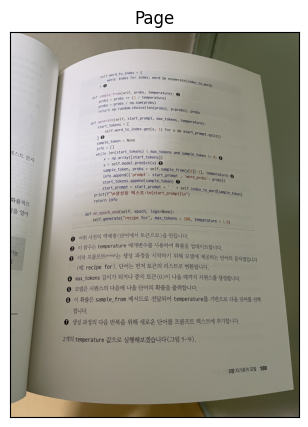

In [6]:
# 테스트 이미지 
IMAGE_PATH = './normal.jpg'
img = cv2.imread(IMAGE_PATH)

# plt.imshow(img)
plt_imshow(['Page'],[img])

시작시간 : 2024-01-08 06:34:38.003165
종료시간 : 2024-01-08 06:34:47.018931
수행시간 : 9 초



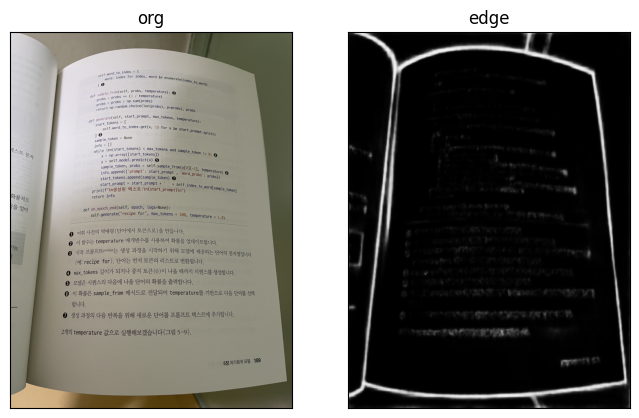

In [7]:
# 모델에 넣어서 edge detection 실행
edge_img = RCF_model.detect_edge(img)
plt_imshow(['org','edge'], [img,edge_img])

# 책의 페이지는 골곡진 경계선으로 인해 인식이 안된다

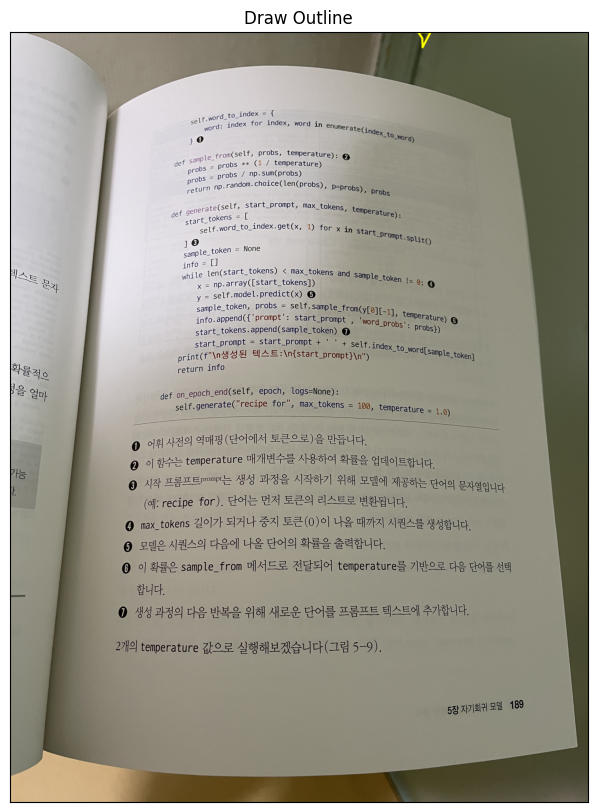

In [8]:
receiptCnt = find_contours(edge_img, 127)
draw_contours(img, receiptCnt)

시작시간 : 2024-01-08 06:35:00.982181
종료시간 : 2024-01-08 06:35:07.527532
수행시간 : 6 초



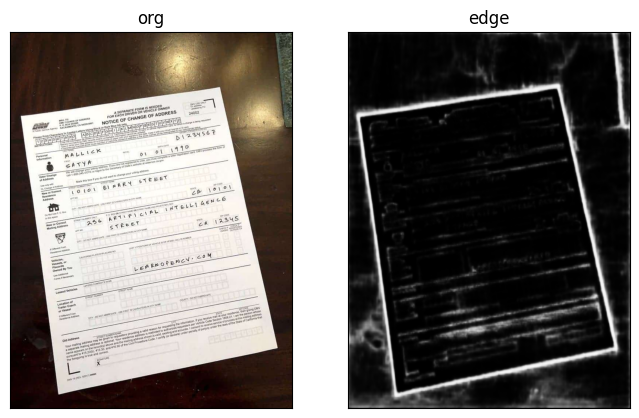

In [9]:
# 일반 문서로 테스트
IMAGE_PATH2 = './Form-2.jpg'
img2 = cv2.imread(IMAGE_PATH2)
edge_img2 = RCF_model.detect_edge(img2)
plt_imshow(['org','edge'], [img2,edge_img2])

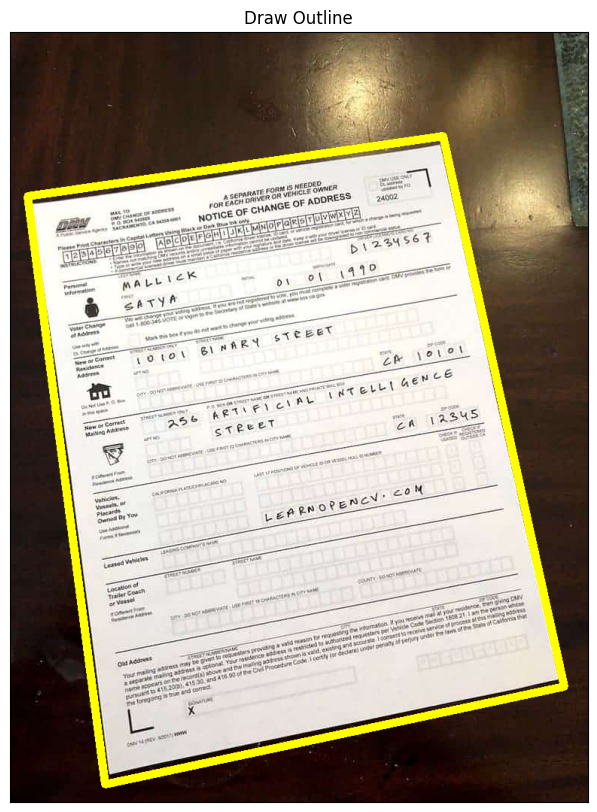

In [10]:
receiptCnt2 = find_contours(edge_img2, 127)
draw_contours(img2, receiptCnt2)

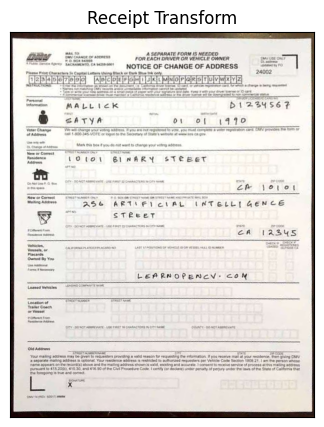

In [11]:
# 찾은 윤곽선을 기준으로 보정
receipt2 = four_point_transform(img2, receiptCnt2.reshape(4, 2))
plt_imshow("Receipt Transform", receipt2)